#### Import

In [1]:
import easyocr
import os
import torch
import matplotlib.pyplot as plt
import random
import glob
from tqdm import tqdm
import numpy as np
import time
from mmocr_eval import eval_ocr_metric

#### Install packges

In [2]:
# !pip install matplotlib
# !pip install rapidfuzz

In [3]:
torch.cuda.is_available()

True

#### Training

Load model by easyOCR API (https://www.jaided.ai/easyocr/documentation/)

In [4]:
start = time.time()
reader = easyocr.Reader(lang_list = ['en','th'],
                        model_storage_directory = os.path.join('my_model','model'),
                        user_network_directory = os.path.join('my_model','user_network'),
                        recog_network  ='crnn_30k_8000-10000_lr_25e-2',
                        gpu = True)
# reader = easyocr.Reader(lang_list = ['en','th'],gpu = True )
end = time.time()
print(f'loading model time: {end - start}')

train_module loaded
my_model/user_network/crnn_30k_8000-10000_lr_25e-2.yaml
Transformation: None
FeatureExtraction: VGG
SequenceModeling: BiLSTM
Prediction: CTC
loading model time: 4.000404596328735


visualise testing with some image

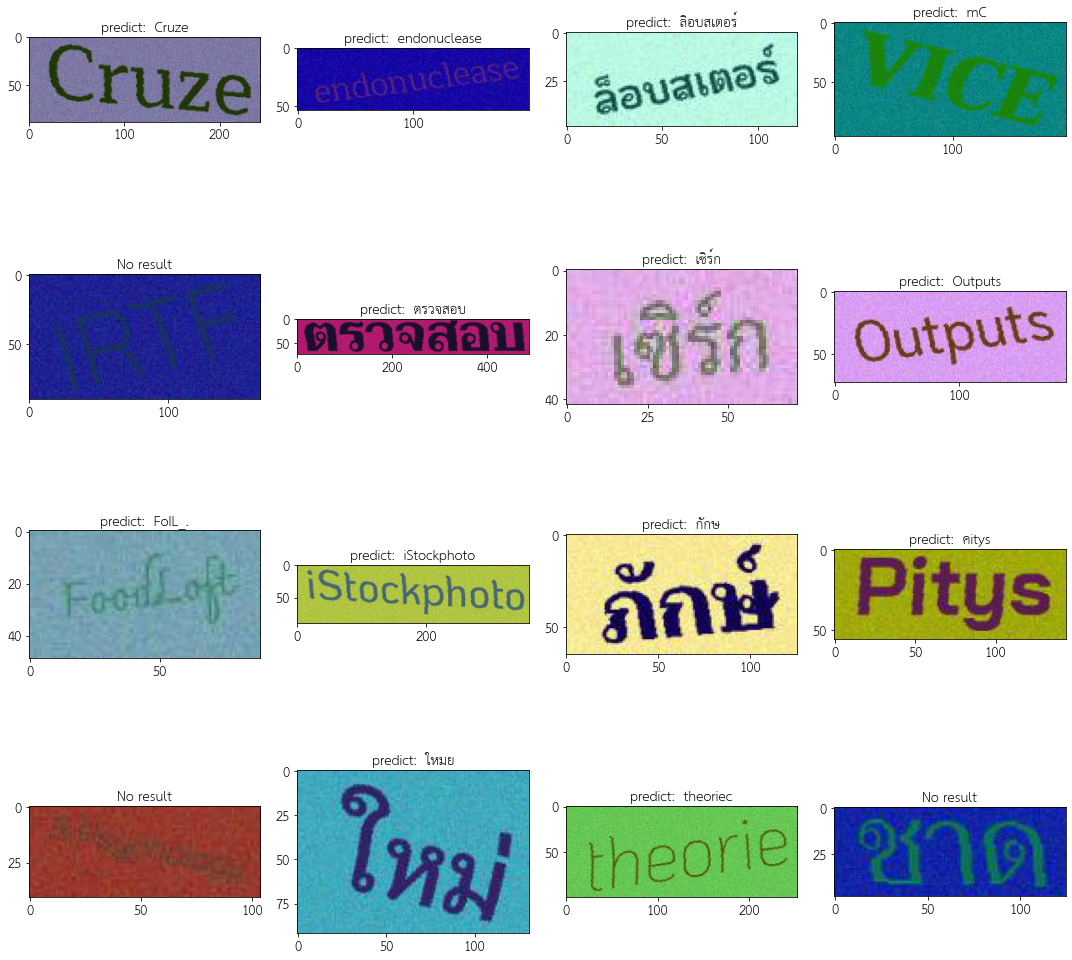

In [5]:
plt.rcParams['font.family'] = 'TH Sarabun New'
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
columns = 4
rows = 4
fig = plt.figure(figsize=(15, 15))
ax = []
for i in range(columns*rows):
    random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
    random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
    #random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
    # random_file_name = os.listdir(os.path.join('trainer/all_data/testing/testing'))[2]
    # random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
    img = plt.imread(random_file_path)
    result = reader.readtext(random_file_path) 
    ax.append(fig.add_subplot(rows, columns, i+1) )
    if len(result) > 0:
        txt = ''
        for i in result:
            txt += (' '+i[1])
        ax[-1].set_title(f'predict: {txt}',fontsize=20)
    else:
        ax[-1].set_title('No result',fontsize=20)
    plt.imshow(img)
fig.tight_layout() 
plt.show()

testing with all files in dataset

In [11]:
filenames = glob.glob(os.path.join('trainer/all_data/testing/testing','*.jpg'))
label_path = 'trainer/all_data/testing/testing/label.txt'
with open(label_path, encoding='utf8') as file:
    label = np.loadtxt(file,dtype=str)
word_correct = 0
print(filenames[0])
#window
#filenames = sorted(filenames, key= lambda x: int(x.split('/')[-1].split('\\')[1].split('.')[0]))

#mac
filenames = sorted(filenames, key= lambda x: int(x.split('/')[-1].split('.')[0]))
start = time.time()
# filenames = filenames[:10]
pred = []
gt = [] # ground truth
for i in tqdm(range(len(filenames))):
    label_img = label[i][1]

    result = reader.readtext(filenames[i], batch_size = 8)
    try:
        pred.append(result[0][1])
        gt.append(label_img)
    except:
        pred.append('')
        gt.append(label_img)
end = time.time()
output = eval_ocr_metric(pred, gt)
for k,v in output.items():
    print(f'{k}: {v}')
print(f'time: {end - start}')

trainer/all_data/testing/testing/308.jpg


100%|██████████| 1000/1000 [00:17<00:00, 56.81it/s]

char_recall: 0.777
char_precision: 0.929
word_acc: 0.405
word_acc_ignore_case: 0.425
word_acc_ignore_case_symbol: 0.745
1-N.E.D: 0.8631
time: 17.607064485549927


testing with LMWN

['เๆตส']


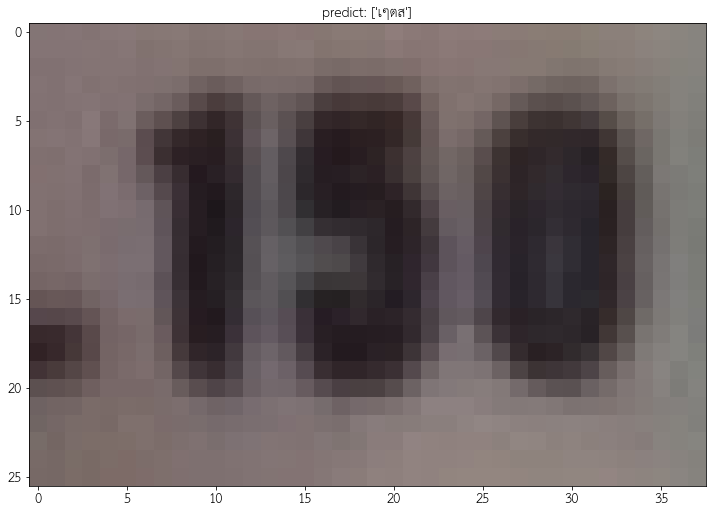

In [7]:
plt.rcParams['font.family'] = 'TH Sarabun New'
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
columns = 2
rows = 10
fig = plt.figure(figsize=(10, 10))
ax = []
for i in range(columns*rows):
    random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/LMWN')),1)[0]
    # random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
    #random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
    # random_file_name = os.listdir(os.path.join('trainer/all_data/testing/LMWN'))[2]
    random_file_path = os.path.join('trainer/all_data/testing/LMWN',random_file_name)
    img = plt.imread(random_file_path)
    result = reader.readtext(random_file_path,detail=0) 
    ax.append(fig.add_subplot(rows, columns, i+1) )
    print(result)
    if len(result) > 0:
        ax[-1].set_title(f'predict: {result}',fontsize=20)
    else:
        ax[-1].set_title('No result',fontsize=20)
    plt.imshow(img)
fig.tight_layout() 
plt.show()